<a href="https://colab.research.google.com/github/ms03831/GANS-google-quick-draw/blob/master/GANS_quick_draw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#all the imports we need
import urllib.request
import numpy as np
import urllib.request
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2DTranspose, LeakyReLU, Softmax, Conv2D, Dropout, Flatten, Input, MaxPooling2D
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline  

### Instead of downloading the dataset manually and then uploading it to colab/drive, what I did was that I used python's urllib request and through that I downloaded the dataset directly from google's storage as you can see below. This is particularly interesting and helpful because by this i can just change the category in data_path and generate new category images by training on them.  

In [ ]:
data_path = 'eye.npy'

def get_data():
    path = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' + data_path
    urllib.request.urlretrieve(path, data_path)
get_data()

**Here we load the data downloaded above, and do some natural pre-processing, that is, we normalise it between 0 and 1 and also reshape it according to how we are going to use it in our network.**

> We also define a **plot_images** utility function, to help us plot as many images as we want my just specifying n number of images.



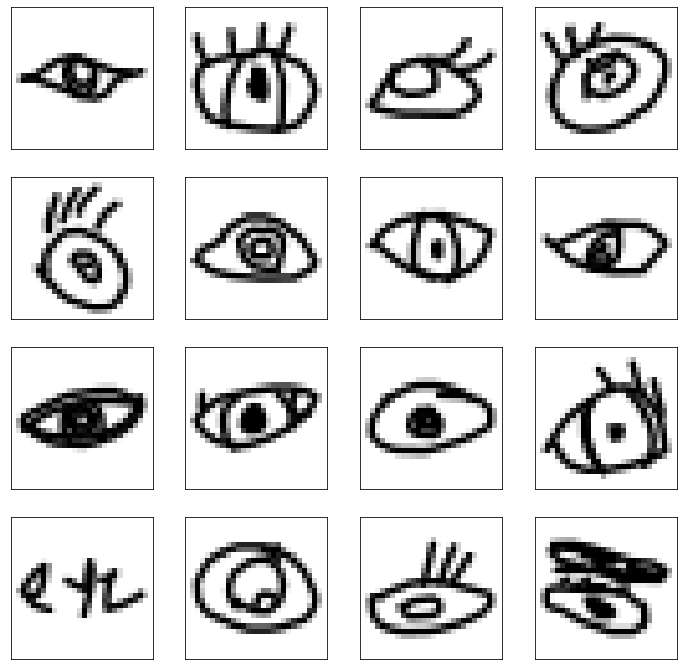

(40000, 28, 28)

In [ ]:
data = np.load(data_path)
data = data.astype(np.float32)/255
data = data[:40000].reshape(-1, 28, 28)

def plot_images(images = [], n = 16, title = None, reshape = True):
    if not len(images):
        images = data
    if n > 10:
        plt.figure(figsize=(12, 12))
    if not reshape: #for stacked images
        plt.imshow(images.reshape(28, -1), cmap = plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        if title: plt.title(title)
        plt.show()
        return
    else:
        rows = np.ceil(np.sqrt(n))
        cols = np.ceil(n/rows)
        for i in range(n):            
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i].reshape(28, 28), cmap = plt.cm.binary)
            plt.xticks([])
            plt.yticks([])
    plt.show()
plot_images()
data.shape

### Here we define our generator and generate a random image (which is basically noise) using it to see that it's not yet trained. We will see later how after training this can generate images of eyes.

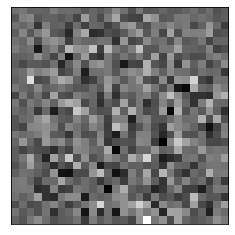

In [ ]:
def get_generator(latent_d):
    model = Sequential([
        Dense(7 * 7 * 128, input_shape = [latent_d]), 
        Reshape([7, 7, 128]),
        BatchNormalization(),
        Conv2DTranspose(64, (5, 5), (2, 2), padding = 'same', activation = 'selu'),
        BatchNormalization(),
        Conv2DTranspose(1, (5, 5), (2, 2), padding = 'same', activation = 'tanh')
    ])
    return model

latent_d = 100
generator = get_generator(latent_d)
noise = np.ones(shape = (1, latent_d))
image_fake = generator(noise)
plot_images(image_fake.numpy(), 1)

### Here we define our discrimator and generate classification score for a random image (which is basically noise) using it to see that it's not yet trained.

In [ ]:
def get_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), (2, 2), padding = 'same', input_shape = [28, 28, 1]),
        LeakyReLU(0.2),
        Dropout(0.3),
        Conv2D(128, (5, 5), (2, 2), padding = 'same'),
        LeakyReLU(0.2),
        MaxPooling2D(),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ])
    return model

In [ ]:
discriminator = get_discriminator()
print(discriminator)

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
print("result: ", discriminator(image_fake).numpy()[0][0])
discriminator.trainable = False

result:  0.49949387


## GAN = generator + discriminator model

In [ ]:
gan = tf.keras.models.Sequential(
    [generator, discriminator]
)
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

### The function first generates some random noise and then uses that noise to generate images using the generator. these images are then displayed using the above plot_images function. We also do some pre-processing to plot better images by first multiplying it by 255 and then making the minimum pixel value to be 0 effectively ranging our image in the range [0, 255] this gives better plots


In [ ]:
def generate_samples(n):
    noise = tf.random.normal(shape = (n, latent_d)) 
    images_fake = (generator(noise)*255.0).numpy().astype(int)
    images_fake = images_fake - np.min(images_fake)
    if n < 10: 
        images_fake = np.hstack(images_fake) ##if not too many images, then plot it as one single image. useful for plotting while training
        plot_images(images_fake, n, "Generated Images", False)     # dont reshape stacked image.
    else:      
        plot_images(images_fake, n, "Generated Images")

### Training our generative adversarial network

  0%|          | 0/312 [00:00<?, ?it/s]


EPOCH 1/50 Iterations 1


  1%|          | 2/312 [00:00<00:18, 16.46it/s]


EPOCH 2/50 Iterations 313


 60%|█████▉    | 186/312 [00:11<00:07, 16.13it/s]

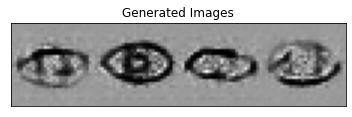

  1%|          | 2/312 [00:00<00:20, 15.36it/s]


EPOCH 3/50 Iterations 625


  1%|          | 2/312 [00:00<00:19, 15.76it/s]


EPOCH 4/50 Iterations 937


 20%|█▉        | 62/312 [00:04<00:17, 14.02it/s]

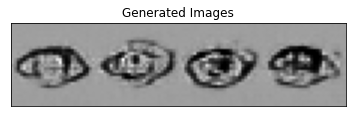

  1%|          | 2/312 [00:00<00:19, 15.66it/s]


EPOCH 5/50 Iterations 1249


 80%|████████  | 250/312 [00:16<00:03, 15.80it/s]

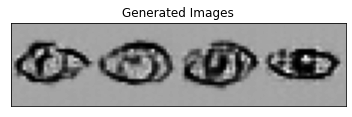

  1%|          | 2/312 [00:00<00:19, 16.01it/s]


EPOCH 6/50 Iterations 1561


  1%|          | 2/312 [00:00<00:19, 16.17it/s]


EPOCH 7/50 Iterations 1873


 40%|████      | 126/312 [00:07<00:11, 15.87it/s]

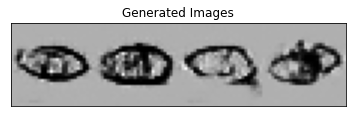

  1%|          | 2/312 [00:00<00:19, 15.71it/s]


EPOCH 8/50 Iterations 2185


  1%|          | 2/312 [00:00<00:19, 15.68it/s]


EPOCH 9/50 Iterations 2497


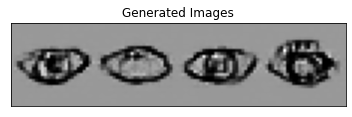

  1%|          | 2/312 [00:00<00:19, 16.04it/s]


EPOCH 10/50 Iterations 2809


 61%|██████    | 190/312 [00:12<00:07, 15.86it/s]

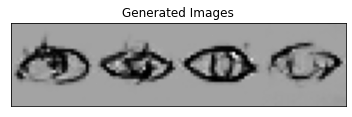

  1%|          | 2/312 [00:00<00:19, 16.20it/s]


EPOCH 11/50 Iterations 3121


  1%|          | 2/312 [00:00<00:19, 15.75it/s]


EPOCH 12/50 Iterations 3433


 21%|██        | 66/312 [00:04<00:15, 15.58it/s]

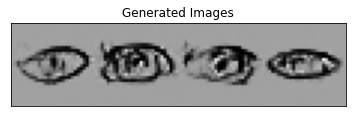

  1%|          | 2/312 [00:00<00:19, 16.09it/s]


EPOCH 13/50 Iterations 3745


 81%|████████▏ | 254/312 [00:16<00:03, 15.93it/s]

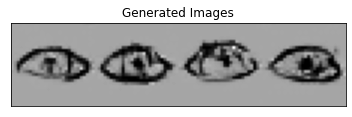

  1%|          | 2/312 [00:00<00:20, 15.46it/s]


EPOCH 14/50 Iterations 4057


  1%|          | 2/312 [00:00<00:19, 15.96it/s]


EPOCH 15/50 Iterations 4369


 42%|████▏     | 130/312 [00:08<00:11, 15.92it/s]

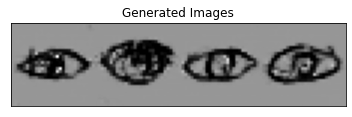

  1%|          | 2/312 [00:00<00:19, 15.91it/s]


EPOCH 16/50 Iterations 4681


  1%|          | 2/312 [00:00<00:20, 15.46it/s]


EPOCH 17/50 Iterations 4993


  2%|▏         | 6/312 [00:00<00:19, 15.45it/s]

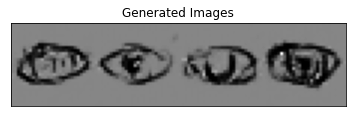

  1%|          | 2/312 [00:00<00:19, 15.90it/s]


EPOCH 18/50 Iterations 5305


 62%|██████▏   | 194/312 [00:12<00:07, 15.63it/s]

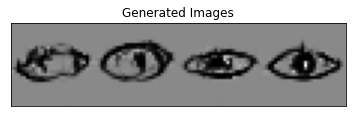

  1%|          | 2/312 [00:00<00:19, 16.14it/s]


EPOCH 19/50 Iterations 5617


  1%|          | 2/312 [00:00<00:19, 16.11it/s]


EPOCH 20/50 Iterations 5929


 22%|██▏       | 70/312 [00:04<00:15, 15.59it/s]

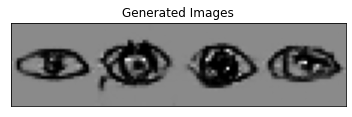

  1%|          | 2/312 [00:00<00:19, 15.59it/s]


EPOCH 21/50 Iterations 6241


 83%|████████▎ | 258/312 [00:16<00:03, 15.93it/s]

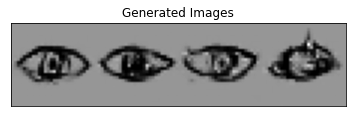

  1%|          | 2/312 [00:00<00:19, 15.59it/s]


EPOCH 22/50 Iterations 6553


  1%|          | 2/312 [00:00<00:19, 15.88it/s]


EPOCH 23/50 Iterations 6865


 43%|████▎     | 134/312 [00:08<00:11, 15.79it/s]

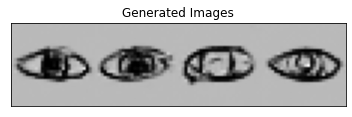

  1%|          | 2/312 [00:00<00:19, 15.62it/s]


EPOCH 24/50 Iterations 7177


  1%|          | 2/312 [00:00<00:19, 15.70it/s]


EPOCH 25/50 Iterations 7489


  3%|▎         | 10/312 [00:00<00:19, 15.72it/s]

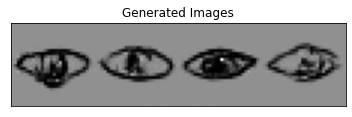

  1%|          | 2/312 [00:00<00:19, 15.83it/s]


EPOCH 26/50 Iterations 7801


 63%|██████▎   | 198/312 [00:12<00:07, 15.87it/s]

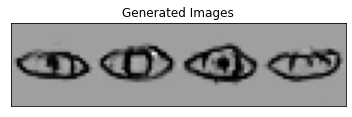

  1%|          | 2/312 [00:00<00:19, 15.95it/s]


EPOCH 27/50 Iterations 8113


  1%|          | 2/312 [00:00<00:19, 16.04it/s]


EPOCH 28/50 Iterations 8425


 24%|██▎       | 74/312 [00:04<00:15, 15.63it/s]

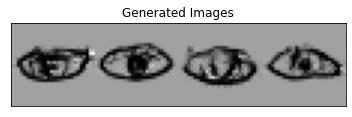

  1%|          | 2/312 [00:00<00:19, 15.94it/s]


EPOCH 29/50 Iterations 8737


 84%|████████▍ | 262/312 [00:16<00:03, 15.74it/s]

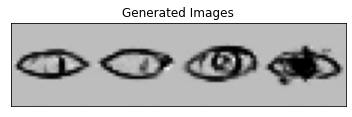

  1%|          | 2/312 [00:00<00:19, 16.06it/s]


EPOCH 30/50 Iterations 9049


  1%|          | 2/312 [00:00<00:19, 15.63it/s]


EPOCH 31/50 Iterations 9361


 44%|████▍     | 138/312 [00:08<00:10, 16.04it/s]

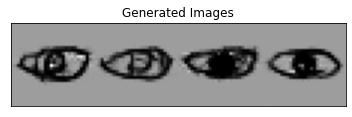

  1%|          | 2/312 [00:00<00:19, 16.07it/s]


EPOCH 32/50 Iterations 9673


  1%|          | 2/312 [00:00<00:19, 15.99it/s]


EPOCH 33/50 Iterations 9985


  4%|▍         | 14/312 [00:00<00:19, 15.50it/s]

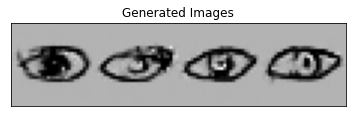

  1%|          | 2/312 [00:00<00:19, 16.15it/s]


EPOCH 34/50 Iterations 10297


 65%|██████▍   | 202/312 [00:12<00:07, 15.61it/s]

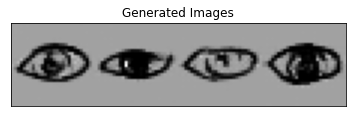

  1%|          | 2/312 [00:00<00:19, 15.85it/s]


EPOCH 35/50 Iterations 10609


  1%|          | 2/312 [00:00<00:19, 16.16it/s]


EPOCH 36/50 Iterations 10921


 25%|██▌       | 78/312 [00:04<00:15, 15.50it/s]

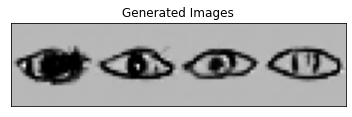

  1%|          | 2/312 [00:00<00:18, 16.42it/s]


EPOCH 37/50 Iterations 11233


 85%|████████▌ | 266/312 [00:16<00:02, 15.99it/s]

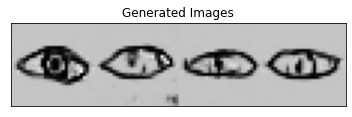

  1%|          | 2/312 [00:00<00:19, 16.09it/s]


EPOCH 38/50 Iterations 11545


  1%|          | 2/312 [00:00<00:20, 15.38it/s]


EPOCH 39/50 Iterations 11857


 46%|████▌     | 142/312 [00:09<00:10, 15.60it/s]

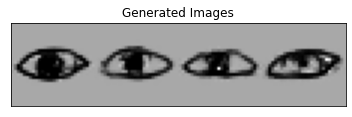

  1%|          | 2/312 [00:00<00:20, 15.22it/s]


EPOCH 40/50 Iterations 12169


  1%|          | 2/312 [00:00<00:19, 16.07it/s]


EPOCH 41/50 Iterations 12481


  6%|▌         | 18/312 [00:01<00:19, 15.40it/s]

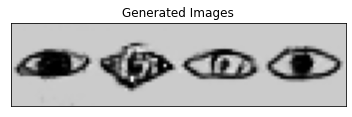

  1%|          | 2/312 [00:00<00:19, 16.25it/s]


EPOCH 42/50 Iterations 12793


 66%|██████▌   | 206/312 [00:12<00:06, 16.06it/s]

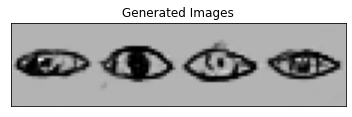

  1%|          | 2/312 [00:00<00:18, 16.38it/s]


EPOCH 43/50 Iterations 13105


  1%|          | 2/312 [00:00<00:19, 15.99it/s]


EPOCH 44/50 Iterations 13417


 26%|██▋       | 82/312 [00:05<00:14, 15.96it/s]

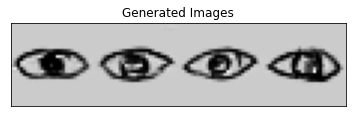

  1%|          | 2/312 [00:00<00:19, 16.06it/s]


EPOCH 45/50 Iterations 13729


 87%|████████▋ | 270/312 [00:16<00:02, 15.99it/s]

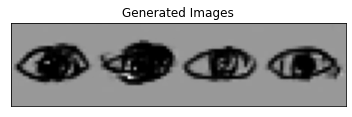

  1%|          | 2/312 [00:00<00:19, 16.17it/s]


EPOCH 46/50 Iterations 14041


  1%|          | 2/312 [00:00<00:18, 16.34it/s]


EPOCH 47/50 Iterations 14353


 47%|████▋     | 146/312 [00:09<00:10, 15.99it/s]

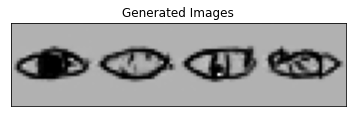

  1%|          | 2/312 [00:00<00:19, 16.10it/s]


EPOCH 48/50 Iterations 14665


  1%|          | 2/312 [00:00<00:19, 16.24it/s]


EPOCH 49/50 Iterations 14977


  7%|▋         | 22/312 [00:01<00:17, 16.11it/s]

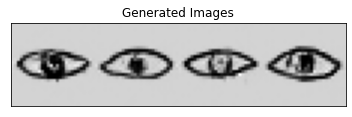

  1%|          | 2/312 [00:00<00:18, 16.43it/s]


EPOCH 50/50 Iterations 15289


 67%|██████▋   | 210/312 [00:13<00:06, 15.97it/s]

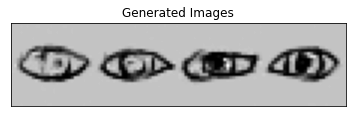

100%|██████████| 312/312 [00:19<00:00, 15.99it/s]


In [ ]:
epochs = 50 #this is the number of epochs, not the iterations. each epoch has about 40000//128 iterations
batch_size = 128
g_losses, d_losses = [], []

def train_gan(epochs, batch_size, data, gan, discriminator, generator):
    iteration_count = 0
    for i in range(epochs):
        print("\nEPOCH {}/{} Iterations {}".format(i+1, epochs, iteration_count+1))
        for batch_start in tqdm(range(0, len(data) - batch_size, batch_size), position=0, leave=True):
            iteration_count += 1
            batch_data = data[batch_start:batch_start+batch_size].reshape(batch_size, 28, 28, 1)
            noise = tf.random.normal(shape = (batch_size, latent_d)) #np.ones(shape = (batch_size, latent_d))
            images_fake = generator(noise)
            real_fake = tf.concat([batch_data, images_fake], axis = 0)
            real_fake_y = tf.concat([tf.constant([[1.]]*batch_size), tf.constant([[0.]]*batch_size)], axis = 0)
            d_loss = discriminator.train_on_batch(real_fake, real_fake_y)
            y_ = tf.constant([[1.]]*batch_size)
            g_loss = gan.train_on_batch(noise, y_)
            
            if iteration_count % 500 == 0:
                generate_samples(4)
                g_losses.append(g_loss)
                d_losses.append(d_loss)

train_gan(epochs, batch_size, data, gan, discriminator, generator)

# Generate and display 20 images

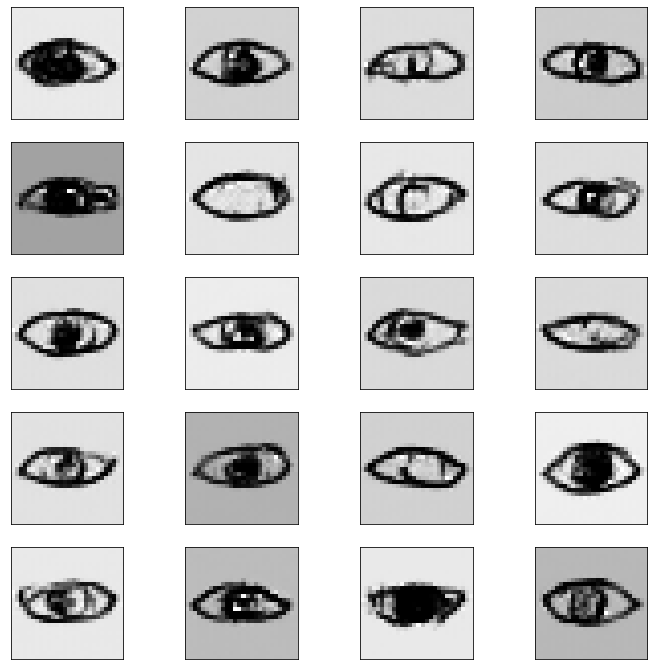

In [ ]:
generate_samples(20)

### The losses are saved once every 500 iterations to get a viewable figure.

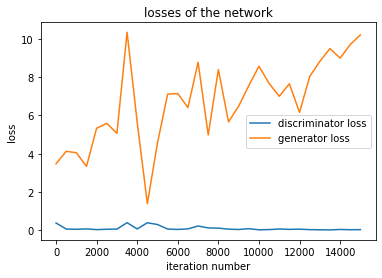

In [ ]:
plt.plot([500*i for i in range(len(g_losses))], d_losses, label = 'discriminator loss')
plt.plot([500*i for i in range(len(g_losses))], g_losses, label = 'generator loss')
plt.legend()
plt.ylabel('loss'); plt.xlabel('iteration number')
plt.title("losses of the network")
plt.show()

### Instead of training the discriminator separately for real and fake images, we concat our real and fake images as well as their corresponding labels, (0 and 1) using tf.concat. and then pass it to the discriminator. This is slightly faster because of less overhead. I faced a lot of issues when trying to do this in tensorflow 2. So I switched to tensorflow1, made it work, and then made it work in tensorflow 2 as well.